In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

torch.manual_seed(42)

Ricarichiamo e riutilizziamo il dataset precedente.

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

## Creiamo i DataLoader


In [4]:
batch_size = 64

# Crea i data loader.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Forma e dimensioni di X [N, C, H, W]: {X.shape}")
    print(f"Forma e dimensioni di y [N]: {y.shape} {y.dtype}")
    break

Forma e dimensioni di X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Forma e dimensioni di y [N]: torch.Size([64]) torch.int64


Verifica delle funzionalità

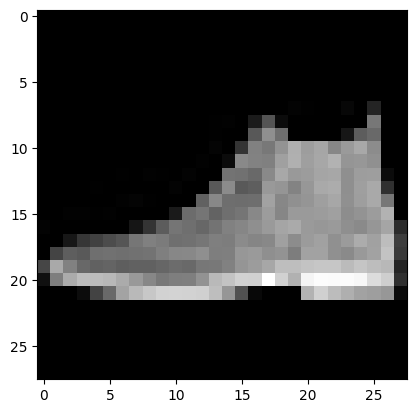

In [5]:
from matplotlib import pyplot as plt

channel=0
plt.imshow(X[0,channel,...], cmap='gray')

## Esploriamo i filtri di Sobel

Per illustrare il funzionamento delle convoluzioni proveremo a precaricare i pesi con i valori relativi ai filtri di Sobel.

In particolare useremo i filtri per identificare i bordi verticali e orizzontali.

In [6]:
# Define the Sobel filters as fixed weights for the convolutional layer
# Sobel filter for detecting horizontal edges
sobel_horizontal = torch.tensor([[-1., -2., -1.],
                                 [ 0.,  0.,  0.],
                                 [ 1.,  2.,  1.]]).view(1, 1, 3, 3)

# Sobel filter for detecting vertical edges
sobel_vertical = torch.tensor([[-1., 0., 1.],
                               [-2., 0., 2.],
                               [-1., 0., 1.]]).view(1, 1, 3, 3)

# Combine the filters into a single tensor
sobel_filters = torch.cat([sobel_horizontal, sobel_vertical], dim=0)

In [7]:

# Create a convolutional layer with 1 input channel and 2 output channels
# Here, the two output channels correspond to the horizontal and vertical Sobel filters
conv = nn.Conv2d(1, 2, kernel_size=3, padding=1, bias=False)

# Manually set the weights of the convolutional layer to the Sobel filters
conv.weight = nn.Parameter(sobel_filters)

# Apply the convolution to the image
# The resulting tensor will have shape [1, 2, 28, 28] due to padding, with 2 channels for horizontal and vertical edges
output = conv(X)

print("Forma dell'output del filtro di Sobel:", output.shape)

Forma dell'output del filtro di Sobel: torch.Size([64, 2, 28, 28])


Come vedete dalla forma di `output` abbiamo ottenuto due immagini diverse, un'immagine per ciascuno dei due filtri, per ognuna delle 64 immagini del primo batch.

Andiamo a visualizzare le 2 immagini ottenute per il primo elemento del blocco.

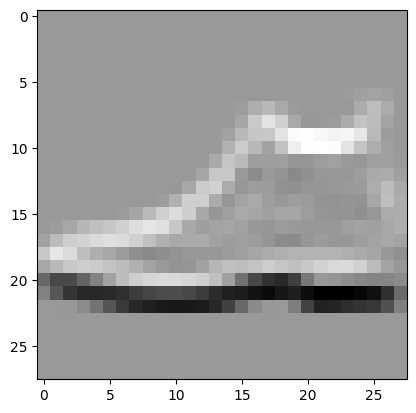

In [8]:
plt.imshow(output[0,0,...].detach().numpy(), cmap='gray')

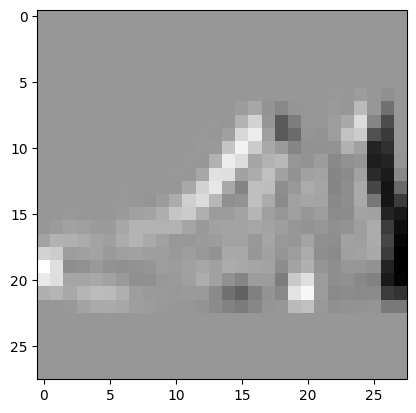

In [9]:
plt.imshow(output[0,1,...].detach().numpy(), cmap='gray')

Come atteso il primo filtro ha evidenziato i bordi orizzontali, mentre il secondo filtro ha evidenziato i bordi verticali.

Se prendiamo un'immagine naturale, otteniamo lo stesso risultato.

In [10]:
!curl -q https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg/128px-Tabby_cat_with_blue_eyes-3336579.jpg -o cat.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6332  100  6332    0     0  26682      0 --:--:-- --:--:-- --:--:-- 26830


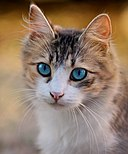

In [11]:
from PIL import Image

img = Image.open('cat.jpg')
img = img.convert('RGB')
img

In [12]:
import torchvision.transforms as transforms

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((28, 28)), # Resize the image to 28x28 pixels
    transforms.ToTensor(), # Convert the image to a PyTorch tensor
])

# Apply the transformation to the image
image_tensor = transform(img)

# Add a batch dimension to the tensor
# PyTorch convolutional layers expect inputs in the shape [batch_size, channels, height, width],
# so we use unsqueeze(0) to add a batch dimension of size 1 at the beginning
image_tensor = image_tensor.unsqueeze(0)

In [13]:
image_tensor.shape

torch.Size([1, 3, 28, 28])

Ora abbiamo in ingresso delle immagini con 3 canali, un canale per ciascuno dei colori che compongono un'immagine a colori.

I filtri di Sobel dovranno quindi essere replicati 3 volte per applicare ciascun filtro a ciascun canale  di ingresso e successivamente aggregare i risultati nei 2 separati canali di uscita, il primo canale d'uscita utile ad evidenziare i bordi orizziontali e il secondo i bordi verticali.

In [14]:
# Replicate filters for each RGB channel
# This changes the second dimension from 1 to 3, indicating the 3 input channels (RGB)
sobel_horizontal_rgb = sobel_horizontal.repeat(1, 3, 1, 1)
sobel_vertical_rgb = sobel_vertical.repeat(1, 3, 1, 1)

# Combine the filters into a single tensor for RGB
sobel_filters_rgb = torch.cat([sobel_horizontal_rgb, sobel_vertical_rgb], dim=0)

print(f"Sobel filters for RGB shape: {sobel_filters_rgb.shape}")

Sobel filters for RGB shape: torch.Size([2, 3, 3, 3])


In [15]:
conv = nn.Conv2d(3, 2, kernel_size=3, padding=1, bias=False)
conv.weight = nn.Parameter(sobel_filters_rgb)

output = conv(image_tensor)

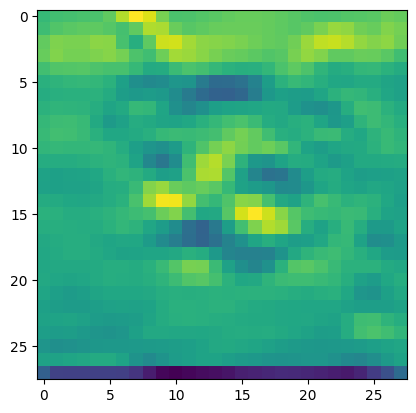

In [16]:
plt.imshow(output[0,0,...].detach().numpy())

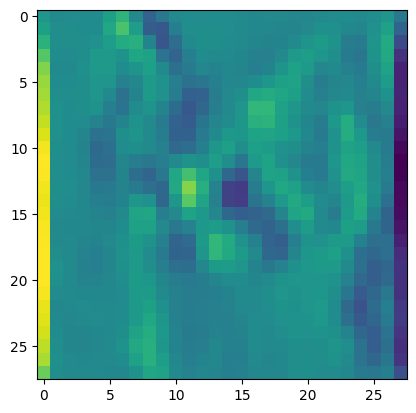

In [17]:
plt.imshow(output[0,1,...].detach().numpy())

--------------




# Architettura della Rete Neurale

Creiamo ora una rete neurale convolutiva basata sull'architettura della prima rete neurale convoluzionale usata per scopi pratici: *LeNet*.
Inventata nel 1989 da Yann LeCun per riconoscere cifre scritte a mano e digitalizzate, aveva un tasso di errore inferiore all'1% e fu successivamente utilizzata per riconoscere le cifre scritte a mano sugli assegni nelle ATM.

Anche questa rete, come l'MLP visto prima, riceve in ingresso delle immagini di dimensioni 28x28 pixel (quindi 768 pixel). In uscita attiva 10 neuroni per classificare l'immagine in una di 10 categorie (nella versione originale le 10 cifre, per noi le 10 etichette).

Il diagramma della rete originale è mostrato qui di seguito.

[![Flusso dei dati in LeNet. L'input è un numero scritto a mano, l'output è una probabilità su 10 possibili risultati.](http://d2l.ai/_images/lenet.svg)](https://D2L.ai) Citazione: Zhang, A., Lipton, Z. C., Li, M., & Smola, A. J. (2023). Dive into Deep Learning. Cambridge University Press. [Disponibile su D2L.ai](https://D2L.ai)


La rete LeNet-5 è composta da due parti principali:
* un insieme di due layer convoluzionali chiamato "encoder convoluzionale"
* un gruppo di tre layer completamente connessi noto come "blocco denso". La parte finale è molto simile al MLP che abbiamo già visto.

Ogni blocco convoluzionale comprende un layer convoluzionale, una funzione di attivazione (una sigmoide) e un'operazione di average pooling (sebbene la funzione di attivazione di tipo ReLU e il max-pooling siano più efficaci, nel 1989 non erano ancora stati scoperti).

Ogni layer convoluzionale utilizza un filtro di dimensioni $5\times 5$ e una funzione di attivazione sigmoide. Il primo layer convoluzionale produce 6 canali di output, mentre il secondo ne produce 16.

Ogni operazione di pooling $2\times2$ (con uno stride di 2) riduce la dimensionalità di un fattore 4 tramite il downsampling spaziale.

Il blocco convoluzionale produce dati con forma [dimensione del batch, numero di canali, altezza, larghezza].

Per alimentare l'output dal blocco convoluzionale nel blocco denso, dobbiamo appiattire ogni esempio nel mini-batch, trasformando l'input quadridimensionale nel formato bidimensionale richiesto dai layer completamente connessi.

Il blocco denso di LeNet contiene tre layer completamente connessi con 120, 84 e 10 output, rispettivamente. Poiché stiamo ancora facendo classificazione, il layer di output a 10 dimensioni corrisponde al numero di classi possibili.

## Creazione della LeNet

In [18]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


Come prima, per definire una rete neurale in PyTorch, creiamo una classe che eredita da [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Definiamo inoltre gli strati della rete
nella funzione ``__init__`` e specifichiamo come i dati passeranno attraverso la rete nella funzione ``forward``.


In [19]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Convolutional layer 1: 1 input channel (grayscale image), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # Subsampling (average pooling) layer
        self.pool = nn.AvgPool2d(2, 2)
        # Convolutional layer 2: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layer 1: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Fully connected layer 2: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 84 input features, 10 output features (for 10 classes)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply convolutional layer 1 followed by Sigmoid and pooling
        x = self.pool(F.tanh(self.conv1(x)))
        # Apply convolutional layer 2 followed by Sigmoid and pooling
        x = self.pool(F.tanh(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 16 * 5 * 5)
        # Apply first fully connected layer with Sigmoid
        x = F.tanh(self.fc1(x))
        # Apply second fully connected layer with Sigmoid
        x = F.tanh(self.fc2(x))
        # Apply output layer
        x = self.fc3(x)
        return x

In [20]:
# Create an instance of the LeNet model
model = LeNet().to(device)
print(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Proviamo ora ad usare la rete neurale che abbiamo appena creato grazie al suo metodo `forward`.

Usiamo come input il blocco `X` di 64 immagini che avevamo caricato precedentemente.

Esaminiamo poi il valore dei 10 neuroni per il primo elemento del blocco.

In [21]:
logits = model.forward(X)
print(logits[0])

tensor([-0.0677, -0.0712,  0.0065, -0.0439,  0.0387, -0.0590,  0.0212, -0.0394,
         0.0374, -0.0024], grad_fn=<SelectBackward0>)


Anche in questo il neurone che contiene il valore maggiore deve rappresentare la classe associata all'oggetto rappresentata.

Ancora una volta, prima dell'addestramento, i valori che otteniamo sono casuali.

Procediamo quindi all'addestramento nella fase successiva.

--------------




## Addestramento della rete neurale


Riusiamo la stessa funzione di costo già vista, la [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) e lo stesso algoritmo di ottimizzazione, il *Stochastic Gradient Descent* [`SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).


In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

Anche la funzione `train` non cambia.



In [23]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Controlliamo anche le prestazioni del modello rispetto all'insieme di dati di test per garantire che stia imparando.


In [24]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Il processo di addestramento viene condotto su diverse iterazioni (*epoche*).

Durante ciascuna epoca, il modello impara i parametri per effettuare previsioni migliori.

Se stampiamo l'accuratezza e la `loss` del modello ad ogni epoca; ci aspettiamo che l'accuratezza aumenti e la `loss` diminuisca ad ogni epoca.


In [25]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.313346  [   64/60000]
loss: 1.176695  [ 6464/60000]
loss: 0.687199  [12864/60000]
loss: 0.813933  [19264/60000]
loss: 0.638143  [25664/60000]
loss: 0.654289  [32064/60000]
loss: 0.570984  [38464/60000]
loss: 0.515254  [44864/60000]
loss: 0.568194  [51264/60000]
loss: 0.464107  [57664/60000]
Test Error: 
 Accuracy: 80.7%, Avg loss: 0.524922 

Epoch 2
-------------------------------
loss: 0.411185  [   64/60000]
loss: 0.443416  [ 6464/60000]
loss: 0.336838  [12864/60000]
loss: 0.506273  [19264/60000]
loss: 0.435030  [25664/60000]
loss: 0.458724  [32064/60000]
loss: 0.378442  [38464/60000]
loss: 0.473275  [44864/60000]
loss: 0.585039  [51264/60000]
loss: 0.397754  [57664/60000]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.456350 

Epoch 3
-------------------------------
loss: 0.362803  [   64/60000]
loss: 0.327711  [ 6464/60000]
loss: 0.276394  [12864/60000]
loss: 0.431000  [19264/60000]
loss: 0.390994  [25664/60000]
loss: 0.424826  [32064/600

Per approfondimenti [Training your model](optimization_tutorial.html).




--------------




## Modernizziamo la LeNet

Come accennato in precedenza dal 1989 ad oggi diversi miglioramenti sono stati introdotti per velocizzare e migliorare l'apprendimento delle Reti Neurali.

Vediamo ora una carrellata di questi metodi partendo dal *max-pooling* e dalla sostituzione della funzione di attivazione dalla sigmoide alla *ReLU*.

Creiamo quindi una nuova rete che chiameremo `LeNetMaxRelu`.

In [26]:
class LeNetMaxRelu(nn.Module):
    def __init__(self):
        super(LeNetMaxRelu, self).__init__()
        # Convolutional layer 1: 1 input channel (grayscale image), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # Subsampling (max pooling) layer
        self.pool = nn.MaxPool2d(2, 2)
        # Convolutional layer 2: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layer 1: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Fully connected layer 2: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84)
        # Output layer: 84 input features, 10 output features (for 10 classes)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply convolutional layer 1 followed by ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply convolutional layer 2 followed by ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 16 * 5 * 5)
        # Apply first fully connected layer with ReLU
        x = F.relu(self.fc1(x))
        # Apply second fully connected layer with ReLU
        x = F.relu(self.fc2(x))
        # Apply output layer
        x = self.fc3(x)
        return x

In [27]:
# Create an instance of the LeNetMaxRelu model
model = LeNetMaxRelu().to(device)
print(model)

LeNetMaxRelu(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [28]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [29]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295714  [   64/60000]
loss: 1.315357  [ 6464/60000]
loss: 0.667714  [12864/60000]
loss: 0.806602  [19264/60000]
loss: 0.645024  [25664/60000]
loss: 0.683266  [32064/60000]
loss: 0.547065  [38464/60000]
loss: 0.581766  [44864/60000]
loss: 0.648382  [51264/60000]
loss: 0.460143  [57664/60000]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.503575 

Epoch 2
-------------------------------
loss: 0.434902  [   64/60000]
loss: 0.450140  [ 6464/60000]
loss: 0.349929  [12864/60000]
loss: 0.431674  [19264/60000]
loss: 0.497200  [25664/60000]
loss: 0.525443  [32064/60000]
loss: 0.359559  [38464/60000]
loss: 0.528723  [44864/60000]
loss: 0.556781  [51264/60000]
loss: 0.363033  [57664/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.409188 

Epoch 3
-------------------------------
loss: 0.311594  [   64/60000]
loss: 0.335509  [ 6464/60000]
loss: 0.290025  [12864/60000]
loss: 0.325048  [19264/60000]
loss: 0.401876  [25664/60000]
loss: 0.409723  [32064/600

Possiamo fare meglio?

Si possiamo

* sostituire l'ottimizzatore con un algoritmo più moderno: [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)
* introdurre uno strato di regolarizzazione: il [`torch.nn.Dropout`](vhttps://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)


In [30]:
class ModernLeNet(nn.Module):
    def __init__(self):
        super(ModernLeNet, self).__init__()
        # Convolutional layer 1: 1 input channel (grayscale image), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        # Subsampling (max pooling) layer
        self.pool = nn.MaxPool2d(2, 2)
        # Convolutional layer 2: 6 input channels, 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Fully connected layer 1: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # Fully connected layer 2: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84)
        # Dropout layer
        self.dropout = nn.Dropout(p=0.25)
        # Output layer: 84 input features, 10 output features (for 10 classes)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Apply convolutional layer 1 followed by ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Apply convolutional layer 2 followed by ReLU and pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the fully connected layer
        x = x.view(-1, 16 * 5 * 5)
        # Apply first fully connected layer with ReLU
        x = F.relu(self.fc1(x))
        # Apply second fully connected layer with ReLU
        x = F.relu(self.fc2(x))
        # Apply the dropout layer
        x = self.dropout(x)
        # Apply output layer
        x = self.fc3(x)
        return x

In [38]:
# Create an instance of the ModernLeNet model
model = ModernLeNet().to(device)
print(model)

ModernLeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [39]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3)

In [40]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293716  [   64/60000]
loss: 0.722264  [ 6464/60000]
loss: 0.439281  [12864/60000]
loss: 0.538377  [19264/60000]
loss: 0.548997  [25664/60000]
loss: 0.463262  [32064/60000]
loss: 0.436361  [38464/60000]
loss: 0.615798  [44864/60000]
loss: 0.501393  [51264/60000]
loss: 0.470614  [57664/60000]
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.445611 

Epoch 2
-------------------------------
loss: 0.389954  [   64/60000]
loss: 0.330653  [ 6464/60000]
loss: 0.349336  [12864/60000]
loss: 0.387345  [19264/60000]
loss: 0.387316  [25664/60000]
loss: 0.372669  [32064/60000]
loss: 0.337102  [38464/60000]
loss: 0.524568  [44864/60000]
loss: 0.436145  [51264/60000]
loss: 0.396776  [57664/60000]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.356778 

Epoch 3
-------------------------------
loss: 0.302921  [   64/60000]
loss: 0.360136  [ 6464/60000]
loss: 0.285578  [12864/60000]
loss: 0.327831  [19264/60000]
loss: 0.362385  [25664/60000]
loss: 0.383456  [32064/600

## Salvataggio dei Modelli
Un modo comune per salvare un modello è serializzare il dizionario di stato interno (contenente i parametri del modello).



In [41]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Caricamento dei Modelli

Il processo per caricare un modello include la ricreazione della struttura del modello e il caricamento del dizionario di stato al suo interno.



In [42]:
model = ModernLeNet().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Questo modello può ora essere utilizzato per effettuare previsioni.


In [43]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predetto: "{predicted}", Atteso: "{actual}"')

Predetto: "Ankle boot", Atteso: "Ankle boot"


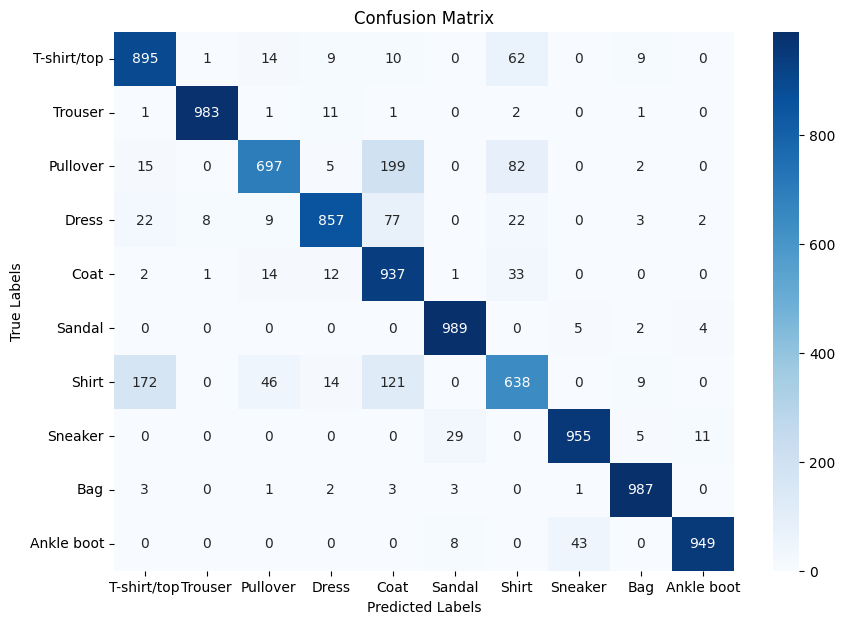

In [44]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Assuming 'model' is your trained PyTorch model and 'test_data' is your DataLoader

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_preds = []
true_labels = []

# No need to track gradients for this
with torch.no_grad():
    for inputs, labels in test_data:
        # Move inputs and labels to the right device
        inputs = inputs.to(device)  # Replace 'device' with your actual device, e.g., 'cuda' if using GPU

        # Forward pass to get outputs
        outputs = model(inputs)

        # Convert outputs probabilities to predicted class by taking the index of the max log-probability
        _, preds = torch.max(outputs, 1)

        # Append batch predictions and labels to the respective lists
        all_preds.extend(preds.view(-1).cpu().numpy())
        true_labels.append(labels)

# Convert lists to numpy arrays for confusion matrix calculation
all_preds = np.array(all_preds)
true_labels = np.array(true_labels)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()